In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, math
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_json(
    'data/chatbot-arena-conversations.jsonl.gz',
    lines=True,
)
scores_df = pd.read_json(
    'data/chatbot-arena-gpt3-scores.jsonl.gz',
    lines=True,
)
df = df.merge(scores_df, left_index=True, right_index=True).drop('question_id_y', axis=1).rename({'question_id_x': 'question_id'}, axis=1)

In [3]:
#taking log of prompt length
df['log_prompt_length'] = np.log(df['prompt'].str.len())

In [4]:
#cleaning the score values and avergaing them
df['score_value_1'] = df['score_value_1'].apply(lambda x: x[0][0] if isinstance(x, list) else x)
df['score_value_2'] = df['score_value_2'].apply(lambda x: x[0][0] if isinstance(x, list) else x)
df['score_value_3'] = df['score_value_3'].apply(lambda x: x[0][0] if isinstance(x, list) else x)
df['score'] = (df['score_value_1'] + df['score_value_2'] + df['score_value_3']) / 3
df['score'] = df['score'].fillna(7).astype(int)

<Axes: xlabel='winner', ylabel='log_prompt_length'>

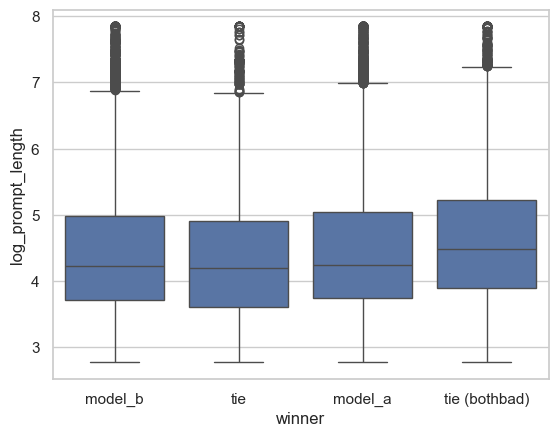

In [5]:
# pliotting distributions of outcomes
sns.boxplot(data=df, x='winner', y='log_prompt_length')

<Axes: xlabel='winner', ylabel='score'>

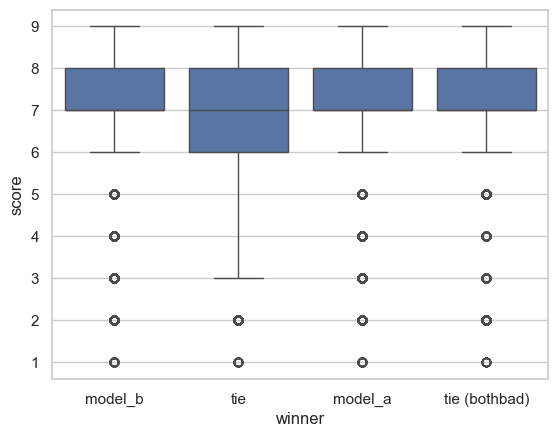

In [6]:
sns.boxplot(data=df, x='winner', y='score')

In [14]:
#looking at high scores and winners
df[df['score']>7]['winner'].value_counts() / len(df[df['score']>7])

winner
model_a          0.358853
model_b          0.348142
tie (bothbad)    0.193443
tie              0.099562
Name: count, dtype: float64

In [15]:
#looking at high scores and winners
df[df['score']<5]['winner'].value_counts() / len(df[df['score']<5])

winner
model_b          0.346582
model_a          0.335438
tie              0.177935
tie (bothbad)    0.140045
Name: count, dtype: float64

In [12]:
df['winner'].value_counts() / len(df)

winner
model_a          0.356172
model_b          0.350407
tie (bothbad)    0.183279
tie              0.110141
Name: count, dtype: float64

In [23]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2)

In [24]:
embeddings = np.load('data/chatbot-arena-prompts-embeddings.npy')

In [45]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=25)
cluster.fit(embeddings[df_train.index])
df_train['cluster'] = cluster.predict(embeddings[df_train.index])
df_val['cluster'] = cluster.predict(embeddings[df_val.index])

In [46]:
# Concatenate counts and tie counts of clusters from training and validation sets
cluster_df = (
    pd.concat([
        df_train['cluster'].value_counts().rename('train count'),
        df_val['cluster'].value_counts().rename('val count'),
        df_train[df_train['winner'] == 'tie']['cluster'].value_counts().rename('train tie count'),
        df_val[df_val['winner'] == 'tie']['cluster'].value_counts().rename('val tie count'),
        df_train[df_train['winner'] == 'tie (bothbad)']['cluster'].value_counts().rename('train bad tie count'),
        df_val[df_val['winner'] == 'tie (bothbad)']['cluster'].value_counts().rename('val bad tie count')
    ], axis=1)
)

In [47]:
#percentage of ties and bad ties in both training and validation sets
cluster_df['train percent tie'] = cluster_df['train tie count'] / cluster_df['train count']
cluster_df['train percent bad tie'] = cluster_df['train bad tie count'] / cluster_df['train count']
cluster_df['val percent tie'] = cluster_df['val tie count'] / cluster_df['val count']
cluster_df['val percent bad tie'] = cluster_df['val bad tie count'] / cluster_df['val count']

In [48]:
cluster_df

,train count,val count,train tie count,val tie count,train bad tie count,val bad tie count,train percent tie,train percent bad tie,val percent tie,val percent bad tie
cluster,,,,,,,,,,
24,1343,366,142,32,296,88,0.105733,0.220402,0.087432,0.240437
13,1277,336,169,39,156,38,0.132341,0.122161,0.116071,0.113095
16,1184,306,139,37,154,30,0.117399,0.130068,0.120915,0.098039
18,1075,267,171,34,181,41,0.159070,0.168372,0.127341,0.153558
5,1057,242,89,14,304,69,0.084201,0.287606,0.057851,0.285124
6,968,229,85,16,169,46,0.087810,0.174587,0.069869,0.200873
20,915,218,80,16,110,31,0.087432,0.120219,0.073394,0.142202
3,909,275,114,27,113,19,0.125413,0.124312,0.098182,0.069091
15,907,245,108,21,112,33,0.119074,0.123484,0.085714,0.134694


In [43]:
cluster_df.corr()

,train count,val count,train tie count,val tie count,train bad tie count,val bad tie count,train percent tie,train percent bad tie,val percent tie,val percent bad tie
train count,1.000000,0.974039,0.919887,0.892803,0.598478,0.603107,0.433824,-0.097193,0.416568,-0.161061
val count,0.974039,1.000000,0.921559,0.905172,0.534207,0.582366,0.472938,-0.141220,0.411874,-0.189640
train tie count,0.919887,0.921559,1.000000,0.955327,0.417122,0.438903,0.726970,-0.263890,0.583787,-0.312536
val tie count,0.892803,0.905172,0.955327,1.000000,0.480137,0.502104,0.673057,-0.148996,0.724477,-0.200783
train bad tie count,0.598478,0.534207,0.417122,0.480137,1.000000,0.953569,-0.083096,0.716231,0.214096,0.656640
val bad tie count,0.603107,0.582366,0.438903,0.502104,0.953569,1.000000,-0.024959,0.639838,0.207962,0.647727
train percent tie,0.433824,0.472938,0.726970,0.673057,-0.083096,-0.024959,1.000000,-0.521144,0.715555,-0.511708
train percent bad tie,-0.097193,-0.141220,-0.263890,-0.148996,0.716231,0.639838,-0.521144,1.000000,-0.114925,0.963549
val percent tie,0.416568,0.411874,0.583787,0.724477,0.214096,0.207962,0.715555,-0.114925,1.000000,-0.153968
val percent bad tie,-0.161061,-0.189640,-0.312536,-0.200783,0.656640,0.647727,-0.511708,0.963549,-0.153968,1.000000
